In [ ]:
import pandas as pd
Meta_DS = pd.read_excel('DS_all_data.xlsx',
                        index_col = None,
                        sheet_name = "Meta")
Apple_DS = pd.read_excel('DS_all_data.xlsx',
                         index_col = None,
                         sheet_name = "Apple")
Ebay_DS = pd.read_excel('DS_all_data.xlsx',
                        index_col = None,
                        sheet_name = "Ebay")
Google_DS = pd.read_excel('DS_all_data.xlsx',
                          index_col = None,
                          sheet_name = "Google")

In [ ]:
Apple_DS = Apple_DS.reset_index()
date_vals = Apple_DS.Date.values
Apple_DS['Date'] = date_vals[::-1]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#lots of unnecessary warnings about indexing.
import warnings
warnings.filterwarnings('ignore')

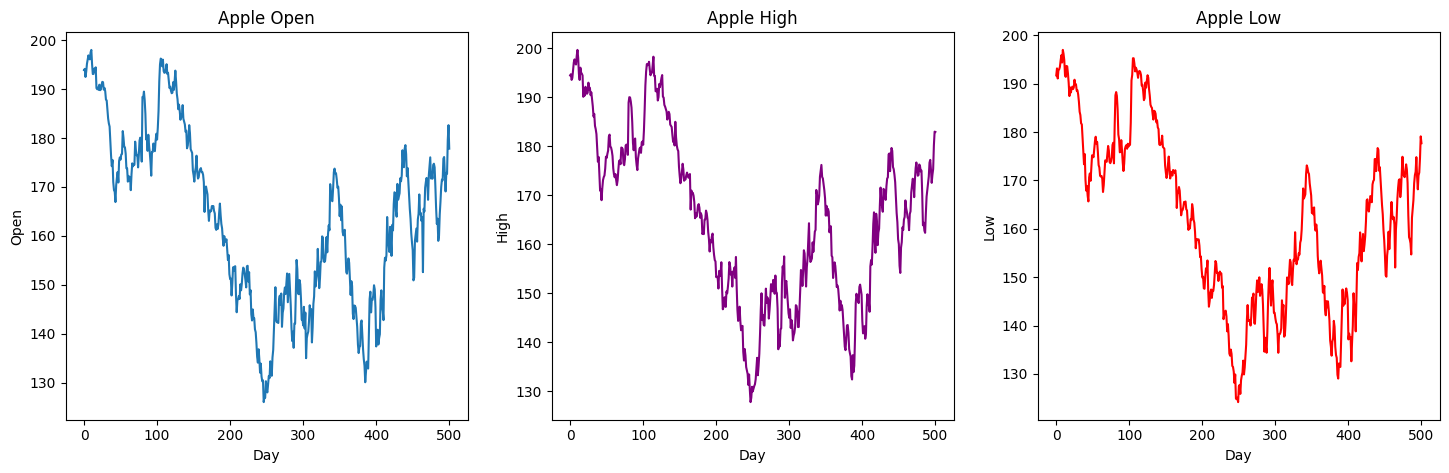

In [ ]:
# intial plot of apple data
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
fig.tight_layout(pad=3.0)
sns.lineplot(data = Apple_DS,
             x=Apple_DS.index,
             y='Open', ax=ax1).set(xlabel = "Day", title = "Apple Open")
sns.lineplot(data=Apple_DS,
             x=Apple_DS.index,
             y='High', ax=ax2, color = 'purple').set(xlabel = "Day",
                                                     title = "Apple High")
sns.lineplot(data=Apple_DS,
             x=Apple_DS.index,
             y='Low', ax=ax3, color = 'red').set(xlabel = "Day",
                                                 title =  "Apple Low")
plt.show()

In [ ]:
Apple_DS['Date'] = pd.to_datetime(Apple_DS['Date'], format = '%d/%m/%y')

In [ ]:
#### beginning a time series analysis####


#starting by checking stationary, a measure of how constant series data is.
#stationary datasets do not have seasonal patterns or trends.

#testing for stationary using Dickey Fuller test. Generates a p value and CVs
# null hypothesis si that there is no stationary.

#because we have a year of data, going to calculate a 12 month rolling mu &sigma
rolling_mean = Apple_DS['Open'].rolling(24).mean()
rolling_std = Apple_DS['Open'].rolling(24).std()

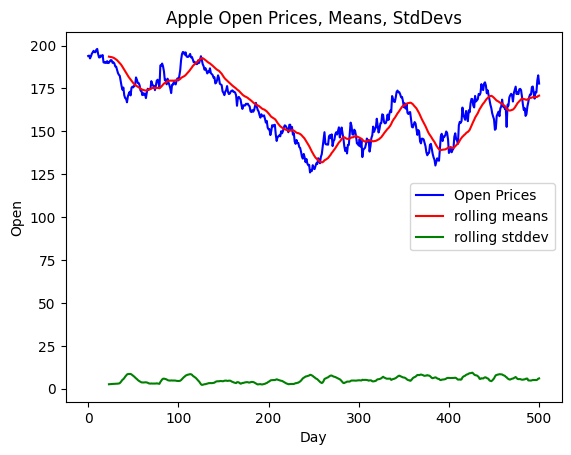

In [ ]:
#starting with just the opening price.

#plot the open data, the rolling mean,
fig, ax = plt.subplots()
sns.lineplot(data = Apple_DS,
             x=Apple_DS.index,
             y='Open',
             color='blue', ax=ax,
             label = "Open Prices").set(xlabel = "Day",  title = "Apple Open Prices, Means, StdDevs")

sns.lineplot(data=rolling_mean, color = 'red', label = 'rolling means')
sns.lineplot(data=rolling_std, color = 'green', label = 'rolling stddev')

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

#chose AIC as the autolag paramater because we choose lag to reduce info criterion
adft = adfuller(Apple_DS["Open"], autolag = "AIC")

#retrieve the results
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -2.154468              Test Statistics
1    0.223184                      p-value
2    0.000000             No. of lags used
3  500.000000  Number of observations used
4   -3.443496          critical value (1%)
5   -2.867338          critical value (5%)
6   -2.569858         critical value (10%)


In [ ]:
#because the p-value (=0.223) is greater than 0.05, our data is not stationary.

In [ ]:
#next we have to check for autocorrelation. This is a measure of how correlated
#time series data of step i is related to steps (1...i-1).
autocorrelation_lag1 = Apple_DS['Open'].autocorr(lag=1)
print("One month lag: ", autocorrelation_lag1)

One month lag:  0.9864721690597359


In [ ]:
#testing at 3, 6, 9 months
autocorrelation_lag3 = Apple_DS['Open'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = Apple_DS['Open'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = Apple_DS['Open'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.9618625506128756
Six Month Lag:  0.9278023426309661
Nine Month Lag:  0.8907069346242551


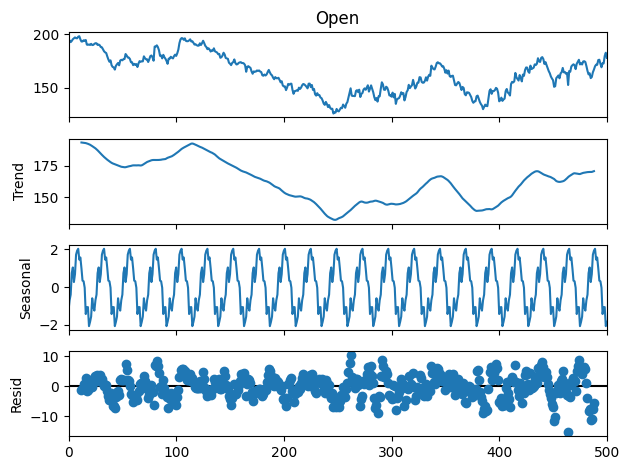

In [ ]:
#Next test is trend decomp, which is used to visualize relevant trends in the data.
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(Apple_DS['Open'],model='additive', period=24)
decompose.plot()
plt.show()

In [ ]:
#FRom the decomposition, there seems to be a very irregular trend in the data.

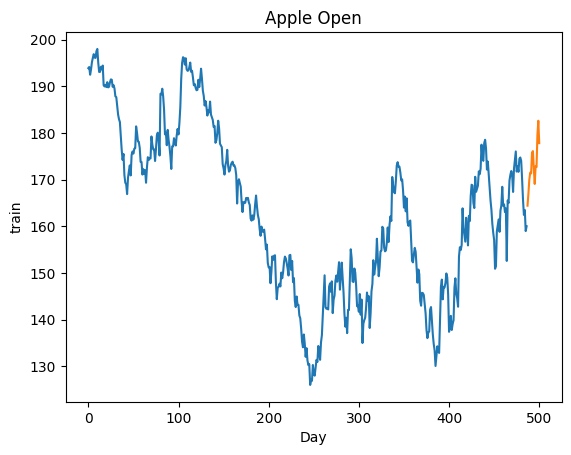

In [ ]:
#finally, we implement the time forecasting to measure future values.

#start with a train-test split of he data. Because we want to test on recent values,
#we do not split the data w shuffle because we want to preserve time-order.
train = Apple_DS[Apple_DS['Date'] < pd.to_datetime("2023-12-09", format='%Y-%m-%d')]
train['train'] = train['Open']

test = Apple_DS[Apple_DS['Date'] >= pd.to_datetime("2023-12-09", format='%Y-%m-%d')]
test['test'] = test['Open']

fig, ax = plt.subplots()
sns.lineplot(data = train,
             x=train.index,
             y='train', ax=ax).set(xlabel = "Day", title = "Apple Open")
sns.lineplot(data = test,  x=test.index,  y='test', ax=ax)
plt.show()

In [ ]:
train2 = pd.concat([train['Date'], train['train']], axis=1, keys=['Date', 'train'])

In [ ]:
test2 = pd.concat([test['Date'], test['test']], axis=1, keys=['Date', 'test'])

In [ ]:
%pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


In [ ]:
#train an arima (time series) model.
from pmdarima.arima import auto_arima
model = auto_arima(train2['train'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train2['train'])
forecast = model.predict(n_periods=len(test2['test']))
forecast = pd.DataFrame(forecast,index = test2.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2420.338, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2415.324, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2415.586, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2415.597, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2413.606, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2416.688, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.650 seconds


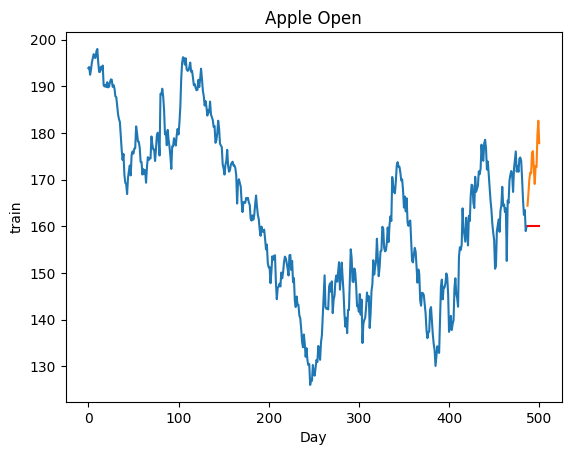

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data = train,
             x=train.index,
             y='train', ax=ax).set(xlabel = "Day", title = "Apple Open")
sns.lineplot(data = test,  x=test.index,  y='test', ax=ax)
sns.lineplot(data = forecast, x=forecast.index, y= 'Prediction', ax=ax, color= 'red')

plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test['Open'],forecast))
print("RMSE: ", rms)

RMSE:  13.905603444038553


In [ ]:
#though there is a low error, it is obvious that the model did not perform that well based
#on the predictions that we observe in the chart.

In [ ]:
# this didn't work too well with our data, possibly because there is limited data.
#so, we will try to use prophet, which is a Meta model used for data that is
#not stationary

from prophet import Prophet
import numpy as np

Apple_prophet_train = pd.concat([train['Date'], train['train']], axis=1, keys=['ds', 'y'])
Apple_prophet_test = pd.concat([test['Date'], test['test']], axis=1, keys=['ds', 'y'])

model = Prophet()
model.fit(Apple_prophet_train)

#predictions
open_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(open_prices)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxtj1hpl/wrx66e99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxtj1hpl/daa6uq50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68542', 'data', 'file=/tmp/tmpfxtj1hpl/wrx66e99.json', 'init=/tmp/tmpfxtj1hpl/daa6uq50.json', 'output', 'file=/tmp/tmpfxtj1hpl/prophet_model84mvepq9/prophet_model-20240422192019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:20:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#rmse
forecast_valid = forecast['yhat'][487:]
rms=np.sqrt(np.mean(np.power((np.array(Apple_prophet_test['y'])-np.array(forecast_valid)),2)))
rms

4.324124683291521

In [ ]:
#RMSE is much better than before.

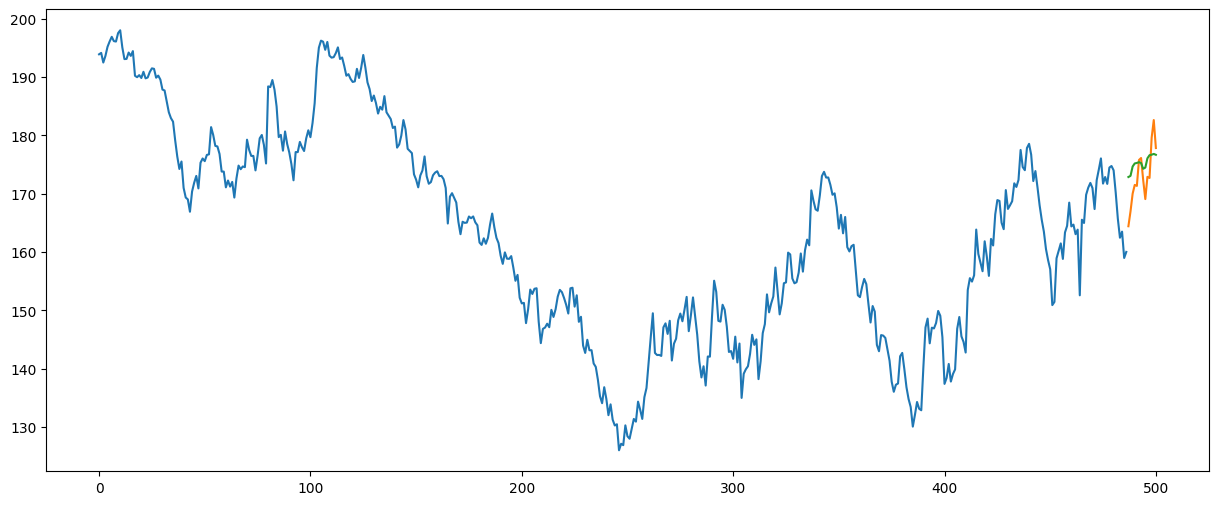

In [ ]:
Apple_prophet_test['Predictions'] = 0
Apple_prophet_test['Predictions'] = forecast_valid.values

fig, ax = plt.subplots(figsize=(15,6))
plt.plot(Apple_prophet_train['y'])
plt.plot(Apple_prophet_test[['y', 'Predictions']])
plt.show()

In [ ]:
#based on the RMSE and the plot, it looks like this version of the time series analysis
#performs better than the Amira one.

In [ ]:
#now straying away from time series analysis, we are trying a deep learning method

#more specifically, LSTM.

In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = Apple_DS
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Open'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Open'][i] = data['Open'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:487,:]
valid = dataset[487:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
res = model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

#predicting 14 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
open_price = model.predict(X_test)
open_price = scaler.inverse_transform(open_price)

Epoch 1/5
427/427 - 7s - loss: 0.0112 - 7s/epoch - 16ms/step
Epoch 2/5
427/427 - 3s - loss: 0.0056 - 3s/epoch - 8ms/step
Epoch 3/5
427/427 - 3s - loss: 0.0041 - 3s/epoch - 6ms/step
Epoch 4/5
427/427 - 3s - loss: 0.0035 - 3s/epoch - 6ms/step
Epoch 5/5
427/427 - 3s - loss: 0.0030 - 3s/epoch - 6ms/step
1/1 [==============================] - 1s 700ms/step


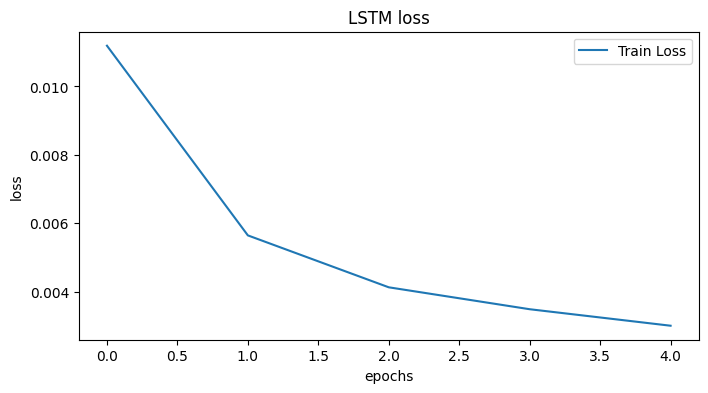

In [ ]:
history = res
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-open_price),2)))
rms

4.026454334541747

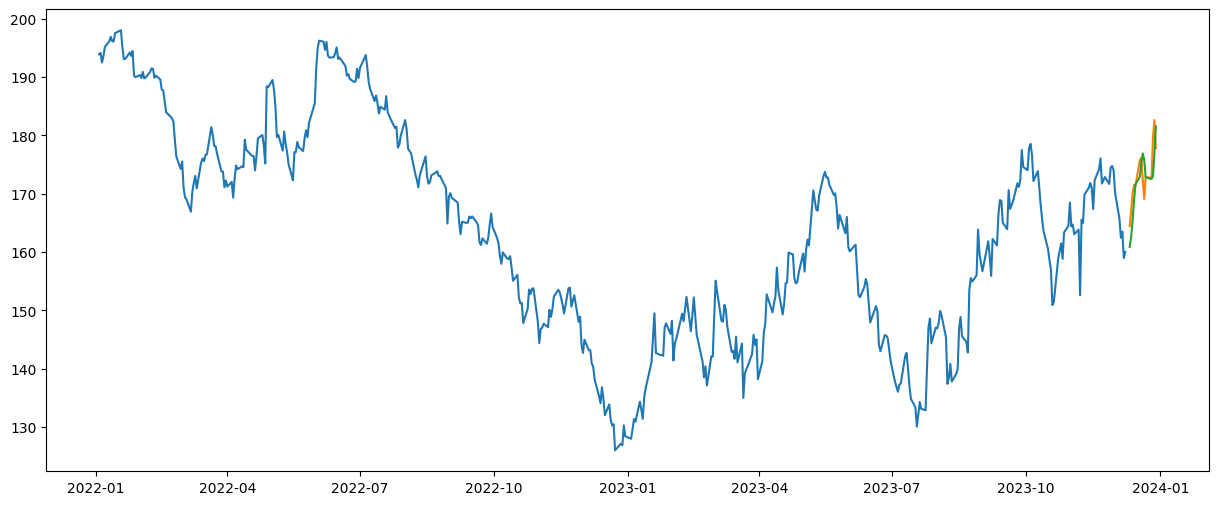

In [ ]:
#for plotting
fig, ax = plt.subplots(figsize=(15,6))
train = new_data[:487]
valid = new_data[487:]
valid['Predictions'] = open_price
plt.plot(train['Open'])
plt.plot(valid[['Open','Predictions']])
plt.show()

In [ ]:
def generate_results_dataset(preds, ci):
    df = pd.DataFrame()
    df['prediction'] = preds
    if ci >= 0:
        df['upper'] = preds + ci
        df['lower'] = preds - ci
    else:
        df['upper'] = preds - ci
        df['lower'] = preds + ci

    return df

In [ ]:
res = valid['Predictions']-valid['Open']
alpha=0.05
ci = np.quantile(res, 1 - alpha)

df = generate_results_dataset(valid['Predictions'], ci)
df.head()

,prediction,upper,lower
Date,,,
2023-12-11,160.880295,166.204620,155.555969
2023-12-12,162.487839,167.812164,157.163513
2023-12-13,165.343994,170.668320,160.019669
2023-12-14,168.772461,174.096786,163.448135
2023-12-15,171.611099,176.935425,166.286774


In [ ]:
rms = sqrt(mean_squared_error(valid['Open'],valid['Predictions']))
print("RMSE: ", rms)

RMSE:  4.026454334541747


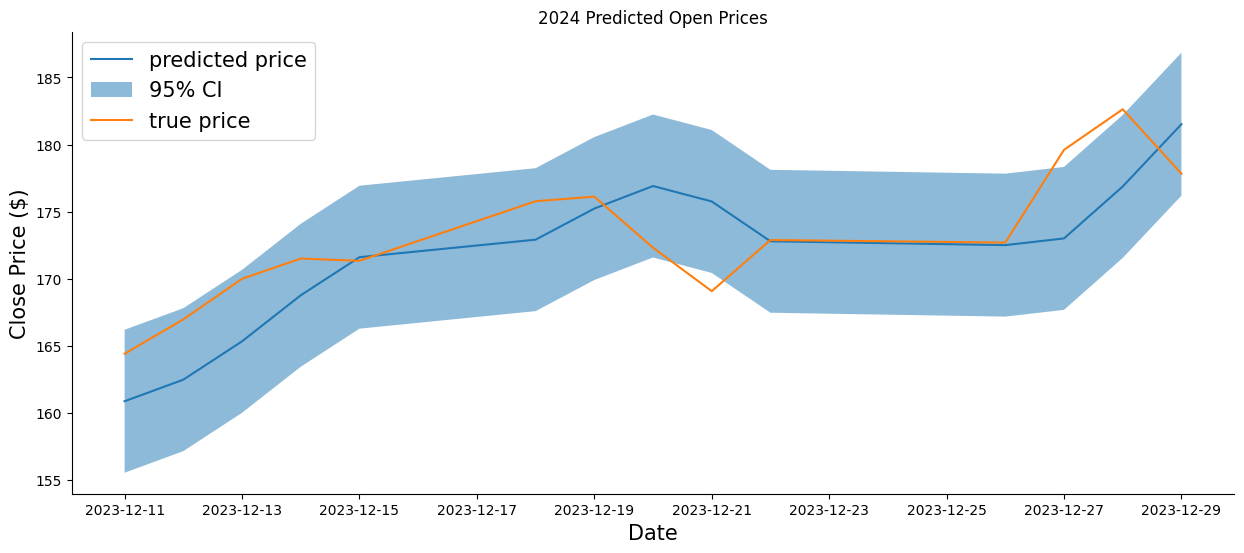

In [ ]:
#for plotting
fig, ax = plt.subplots(figsize=(15,6))
train = new_data[450:487]
valid = new_data[487:]
valid['Predictions'] = open_price
sns.despine(top=True)
sns.lineplot(x=valid.index, y= valid['Predictions'], label='predicted price')
ax.fill_between(x=df.index, y1 = df['lower'], y2 = df['upper'], alpha = 0.5, label ='95% CI')
sns.lineplot(valid['Open'], label='true price')
plt.title('2024 Predicted Open Prices')
plt.ylabel('Close Price ($)', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
#going to do same as above but to predict the first two weeks of 2024.

In [ ]:
Apple_2024 = pd.read_excel('2024_apple.xlsx',
                         index_col = None,
                         sheet_name = "Sheet1")

Apple_2024 = Apple_2024.reset_index()
date_vals = Apple_2024.Date.values
Apple_2024['Date'] = date_vals[::-1]

Apple_2024.head()

,index,Date,Close/Last,Volume,Open,High,Low
0,0,2024-01-02,185.92,40477780,186.06,186.74,185.19
1,1,2024-01-03,185.59,49128410,186.54,187.05,183.62
2,2,2024-01-04,186.19,46792910,184.35,186.40,183.92
3,3,2024-01-05,185.14,42841810,183.92,185.15,182.73
4,4,2024-01-08,185.56,59144470,182.09,185.60,181.50


In [ ]:
df2024 = Apple_2024.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
df2022_23 = Apple_DS.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

In [ ]:
df2022_23.shape

(501, 3)

In [ ]:
df2022_23.head()

,index,Date,Close/Last
0,0,2022-01-03,192.53
1,1,2022-01-04,193.58
2,2,2022-01-05,193.15
3,3,2022-01-06,193.05
4,4,2022-01-07,193.60


In [ ]:
df2024.index = range(501, 510, 1)
df2024.index

RangeIndex(start=501, stop=510, step=1)

In [ ]:
df_all = pd.concat([df2022_23, df2024])


In [ ]:
df_all.tail()

,index,Date,Close/Last
505,4,2024-01-08,185.56
506,5,2024-01-09,181.18
507,6,2024-01-10,181.91
508,7,2024-01-11,184.25
509,8,2024-01-12,185.64


In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df_all
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close/Last'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close/Last'][i] = data['Close/Last'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:501,:]
valid = dataset[501:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
res = model.fit(x_train, y_train, epochs=7, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
close_price = model.predict(X_test)
close_price = scaler.inverse_transform(close_price)

Epoch 1/7
441/441 - 7s - loss: 0.0103 - 7s/epoch - 16ms/step
Epoch 2/7
441/441 - 3s - loss: 0.0055 - 3s/epoch - 7ms/step
Epoch 3/7
441/441 - 3s - loss: 0.0038 - 3s/epoch - 7ms/step
Epoch 4/7
441/441 - 3s - loss: 0.0033 - 3s/epoch - 6ms/step
Epoch 5/7
441/441 - 3s - loss: 0.0029 - 3s/epoch - 6ms/step
Epoch 6/7
441/441 - 3s - loss: 0.0025 - 3s/epoch - 7ms/step
Epoch 7/7
441/441 - 3s - loss: 0.0025 - 3s/epoch - 7ms/step


1/1 [==============================] - 2s 2s/step


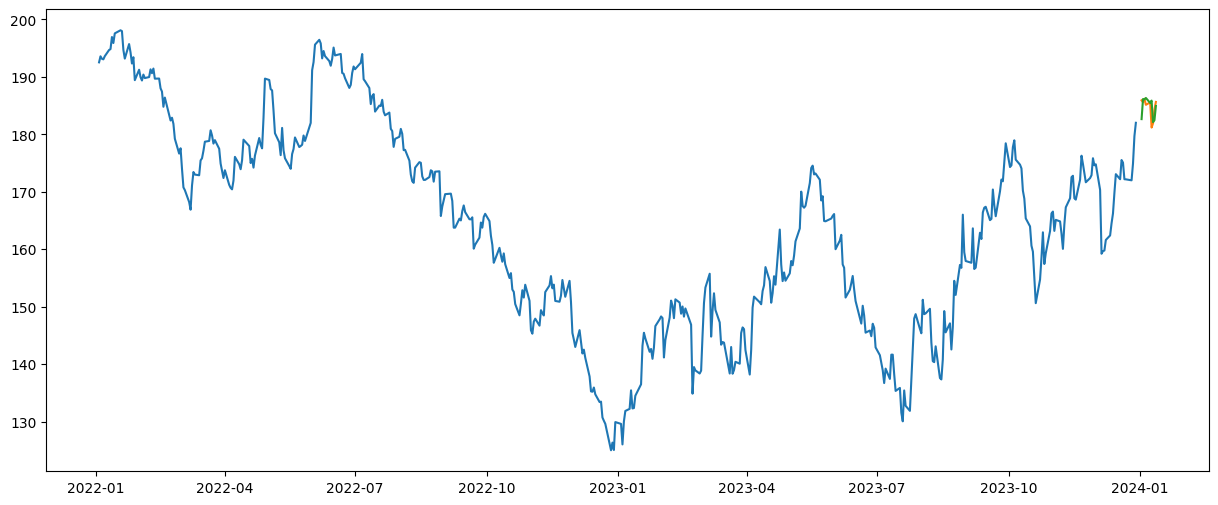

In [ ]:
#for plotting
fig, ax = plt.subplots(figsize=(15,6))
train = new_data[:501]
valid = new_data[501:]
valid['Predictions'] = close_price
plt.plot(train['Close/Last'])
plt.plot(valid[['Close/Last','Predictions']])
plt.show()

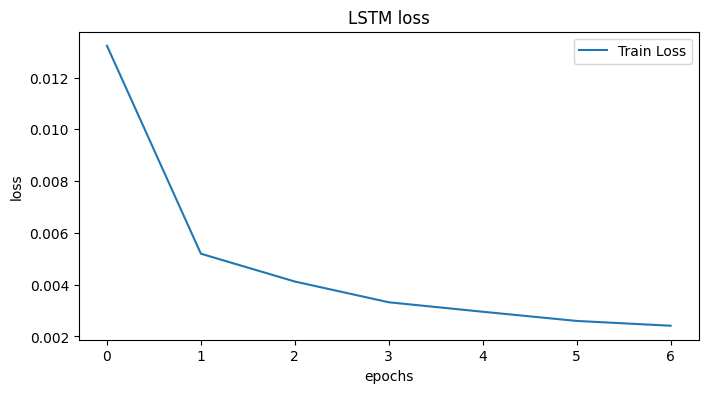

In [ ]:
history = res
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
res = valid['Predictions']-valid['Close/Last']
alpha=0.05
ci = np.quantile(res, 1 - alpha)

df = generate_results_dataset(valid['Predictions'], ci)
df.head()

,prediction,upper,lower
Date,,,
2024-01-02,182.650101,185.944778,179.355423
2024-01-03,186.151337,189.446014,182.856659
2024-01-04,186.061539,189.356216,182.766861
2024-01-05,186.332581,189.627258,183.037903
2024-01-08,185.471024,188.765701,182.176346


In [ ]:
rms = sqrt(mean_squared_error(valid['Close/Last'],valid['Predictions']))
print("RMSE: ", rms)

RMSE:  2.061498962538794


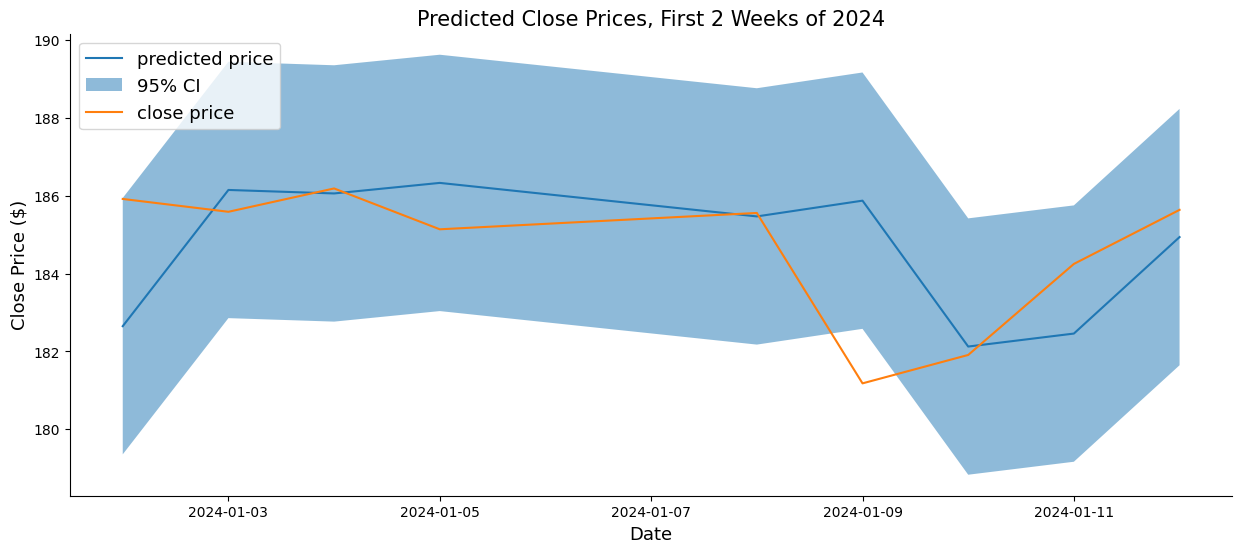

In [ ]:
#for plotting
fig, ax = plt.subplots(figsize=(15,6))
train = new_data[450:501]
valid = new_data[501:]
valid['Predictions'] = close_price


sns.lineplot(x=valid.index, y= valid['Predictions'], label='predicted price')
ax.fill_between(x=df.index, y1 = df['lower'], y2 = df['upper'], alpha = 0.5, label ='95% CI')
sns.lineplot(x=valid.index, y= valid['Close/Last'], label = 'close price')

sns.despine(top=True)
plt.title('Predicted Close Prices, First 2 Weeks of 2024', fontsize = 15)
plt.ylabel('Close Price ($)', fontsize = 13)
plt.xlabel('Date', fontsize = 13)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()